In [1]:
import os
import cv2
import time
import imutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook as tqdm


In [2]:
def rotate_bound(image, angle, borderValue):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w / 2, h / 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH), borderValue=(borderValue,borderValue,borderValue))

In [3]:
y_filter = np.ones((9,9))
y_filter[:4] = -1
y_filter[4] = 0

In [4]:
def sobel(img, dx, dy, ksize):
    sobelx64f = cv2.Sobel(img,cv2.CV_64F,dx,dy,ksize=ksize)
    abs_sobel64f = np.absolute(sobelx64f)
    return np.uint8(abs_sobel64f)

In [5]:
def get_consecutive_coords_above_threshold(sobel_xy, height, width, squ_size, threshold):
    consecutive = 0 
    consecutive_coords = []
    text_coords = []
    for j in range(height//squ_size):
        sy = j*squ_size
        ey = j*squ_size + squ_size
        for i in range(width//squ_size):
            sx = i*squ_size
            ex = i*squ_size + squ_size

            squ = sobel_xy[sy:ey,sx:ex,:]

            _mean = squ.mean()
            if _mean >= threshold:
                consecutive += 1
                consecutive_coords += [(sx,sy,ex,ey)]

            elif consecutive >= 0:
                if consecutive >= min_consecutive:
                    consecutive = 0
                    text_coords += consecutive_coords
                else:
                    consecutive = 0
                    consecutive_coords = []

        if consecutive >= min_consecutive:
            text_coords += consecutive_coords
        consecutive_coords = []
        consecutive = 0
    
    return text_coords

def plot_rectangles(img, rectangles, colors=False):
    if not colors:
        messy = img.copy()
        for (startX, startY, endX, endY) in rectangles:
            cv2.rectangle(messy, (startX, startY), (endX, endY), (0, 255, 0), 2)
    
    if colors:
        colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255),(255,255,255),(100,100,100)]
        messy = img.copy()
        color = 0
        for label in rectangles:
            for (startX, startY, endX, endY) in label:
                cv2.rectangle(messy, (startX, startY), (endX, endY), colors[color], 2)
            color += 1
            if color == len(colors):
                color = 0
    plt.figure()
    plt.imshow(messy)
    
def group_squares_into_words(coords, max_dist_btw_x, max_dist_btw_y,  min_squ_per_label):
    coords_stack = coords.copy()

    labels = []
    while len(coords_stack):
        squ1 = coords_stack[0]
        sx1, sy1, ex1, ey1 = squ1
        mx1 = (sx1+ex1)/2
        my1 = (sy1+ey1)/2

        new_label = []
        to_be_checked = [squ1]
        coords_stack.remove(squ1)

        while len(to_be_checked):
            squ1 = to_be_checked[0]
            sx1, sy1, ex1, ey1 = squ1
            mx1 = (sx1+ex1)/2
            my1 = (sy1+ey1)/2

            new_label += [squ1]
            to_be_checked.remove(squ1)

            coords_stack2 = coords_stack.copy()
            for i in range(len(coords_stack2)):
                squ2 = coords_stack2[i]
                sx2, sy2, ex2, ey2 = squ2
                mx2 = (sx2+ex2)/2
                my2 = (sy2+ey2)/2
                x_dist = np.abs(mx1 - mx2)
                y_dist = np.abs(my1 - my2)
                if (x_dist <= max_dist_btw_x)&(y_dist <= max_dist_btw_y):
                #dist = np.sqrt((mx1-mx2)**2 + (my1-my2)**2)
                #if dist <= max_dist_btw:
                    to_be_checked += [squ2]
                    coords_stack.remove(squ2)
        if len(new_label) >= min_squ_per_label:
            labels += [new_label]
            
    return labels

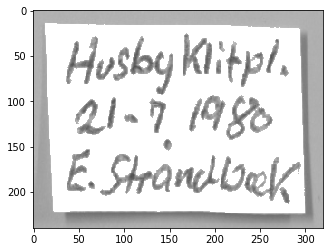

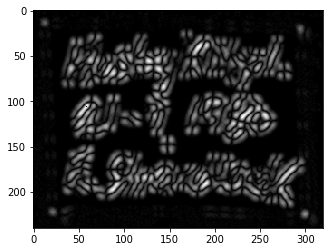

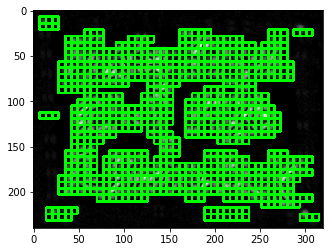

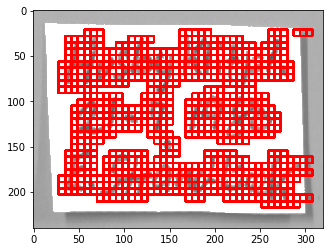

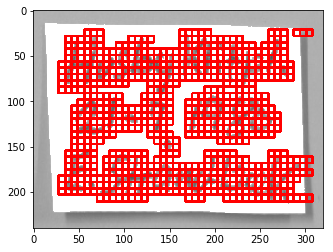

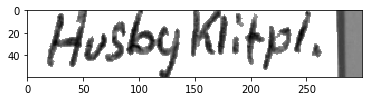

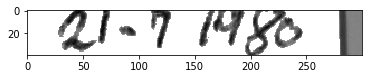

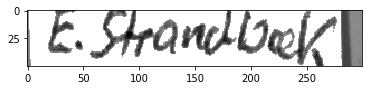

In [8]:

debug = True

folderGlob = '/home/rob/HWR/datasets/Aarhus/yolo_labels/*.jpg'
fps = glob(folderGlob)
if debug == True:
    fps = np.random.permutation(fps)
    
padding = 10
    
    
for fp in tqdm(fps):
    folder = '/'.join(fp.split('/')[:-1])
    fn = fp.split('/')[-1]
    catno = fn.split('_')[0]
    labelno = fn.split('_')[-2]
    _type = fn.split('_')[-1].split('.')[0]
    if _type != 'QR':
        new_img_size = (480//2, 640//2)
        squ_size = 7
        assert squ_size%2 == 1
        max_dist_btw_x = squ_size*2.4
        max_dist_btw_y = squ_size
        min_consecutive = 3
        min_squ_per_label = 40
        threshold = 5
        min_vert_connection_word = 4
        height, width = new_img_size

        orig = cv2.imread(fp)
        orig_size = orig.shape[:2]
        scale = np.array(orig_size) / np.array(new_img_size)
        img = cv2.resize(orig, (width, height))

        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        kmeans = KMeans(n_clusters=2, n_init=1, init=np.array([[0],[255]])).fit(np.expand_dims(img.flatten(),axis=1))
        mask = kmeans.predict(img.reshape(-1,1)).reshape(img.shape)
        img[mask == 1] = 255
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
        blur = cv2.GaussianBlur(img, (11,11), 3)
        sobel_xy = sobel(blur, 1, 1, 5)    

        if debug == True:
            plt.imshow(img)
            plt.grid(False)
            plt.figure()
            plt.imshow(sobel_xy)

        text_coords = get_consecutive_coords_above_threshold(sobel_xy, height, width, squ_size, threshold)
        if debug == True:
            plot_rectangles(sobel_xy, text_coords)


        words = group_squares_into_words(text_coords, max_dist_btw_x, max_dist_btw_y, min_squ_per_label)
        if debug == True:
            plot_rectangles(img, words, colors=True)

        i = 0
        vertically_seperated_words = []
        vertically_seperated_word = []
        for word in words:
            prev_touch = False
            word = np.array(word)
            word = word[word[:,1].argsort()]
            for sy in sorted(np.unique(word[:,1])):
                group = word[word[:,1] == sy].tolist()
                touching= 0
                for squ in group:
                    sx, sy, ex, ey = squ
                    next_sy = sy + squ_size
                    if len(word[(word[:,1]==next_sy)&(word[:,0]==sx)]):
                        touching += 1
                if (prev_touch == False)&(touching < min_vert_connection_word):
                    vertically_seperated_word += group
                elif touching >= min_vert_connection_word:
                    vertically_seperated_word += group
                    prev_touch = True
                elif len(vertically_seperated_word):
                    vertically_seperated_words += [vertically_seperated_word]
                    vertically_seperated_word =  []
                    prev_touch = False


            if len(vertically_seperated_word):
                vertically_seperated_words += [vertically_seperated_word]
                vertically_seperated_word =  []

            i+=1

        final_words = []
        for word in vertically_seperated_words:
            if len(word) >= min_squ_per_label:
                final_words += [word]

        if debug == True:
            plot_rectangles(img, final_words, colors=True)

        words = []
        for word_boxes in final_words:
            word_boxes = np.array(word_boxes)
            
            
            sx = max(word_boxes[:,1].min() - padding,0)
            sy = max(word_boxes[:,0].min() - padding,0)
            ex = min(word_boxes[:,3].max() + padding,new_img_size[0])
            ey = min(word_boxes[:,2].max() + padding,new_img_size[1])
            word_boxes = word_boxes - np.array([sx,sy,sx,sy])
            word_img = cv2.cvtColor(img[sx:ex,sy:ey], cv2.COLOR_BGR2GRAY)
            

            kmeans = KMeans(n_clusters=2, n_init=1, init=np.array([[0],[255]])).fit(np.expand_dims(word_img.flatten(),axis=1))
            mask = kmeans.predict(word_img.reshape(-1,1)).reshape(word_img.shape)
            word_img[mask == 1] = 255

            aspect_ratio = (ex-sx)/(ey-sy)

            if aspect_ratio < 2.5:
                #plt.title(aspect_ratio)
                #maybe there is more than one line
                _mean = word_img.mean()
                n_slices = 20
                slice_height = word_img.shape[0]//n_slices
                seen_word_yet = False
                word_start = 0
                word_end = np.nan
                for slice_no in range(n_slices):
                    sy = slice_no*slice_height
                    ey = sy + slice_height
                    _slice = word_img[sy:ey,:]
                    slice_mean = _slice.mean()
                    #plt.figure()
                    #plt.title(str(slice_mean)+' '+str(_mean + 10))
                    #plt.imshow(_slice)
                    if (slice_mean < _mean + 10):
                        seen_word_yet = True
                    elif (slice_mean >= _mean) & (seen_word_yet == True):
                        #found a break between words
                        word_end = ey
                        if (ex-sx)/(word_end-word_start) < 7:
                            words += [word_img[word_start:word_end]]
                        word_start = ey
                        seen_word_yet == False
                if seen_word_yet:
                    word_end = ey
                    if word_start != word_end:
                        if (ex-sx)/(word_end-word_start) < 7:
                            words += [word_img[word_start:word_end]]

            elif aspect_ratio < 5:
                words += [word_img]
        word_no = 0
        for word in words:
            if debug == True:
                plt.figure()
                plt.imshow(word,'gray')
            #else:

            wordPath = folder.replace('yolo_labels','words') + '/' + catno + '_' + labelno + '_' + _type + '_' + str(word_no) + '.jpg'

            #cv2.imwrite(wordPath, word)
            word_no += 1

        if debug == True:
            break



In [122]:
word_end,word_start

(240, 240)

[21 28 28 35] [189  91 196  98]
[210  28 217  35] [308  84 315  91]
[126 105 133 112] [287 196 294 203]


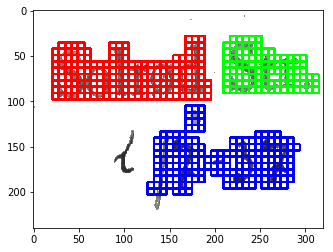

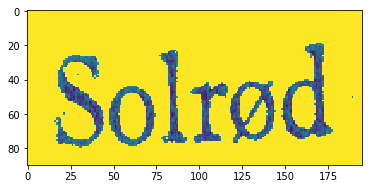

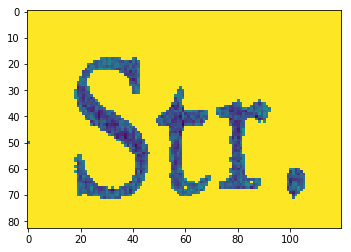

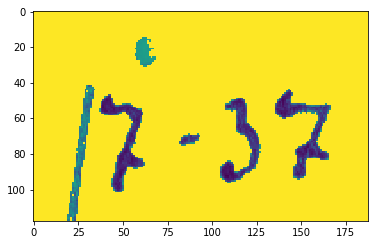

In [84]:
plot_rectangles(img, final_words, colors=True)
for word_boxes in final_words:
    word_boxes = np.array(word_boxes)
    print(word_boxes.min(axis=0),word_boxes.max(axis=0))

    sx = max(word_boxes[:,1].min() - padding,0)
    sy = max(word_boxes[:,0].min() - padding,0)
    ex = min(word_boxes[:,3].max() + padding,new_img_size[0])
    ey = min(word_boxes[:,2].max() + padding,new_img_size[1])
    word_boxes = word_boxes - np.array([sx,sy,sx,sy])
    word_img = cv2.cvtColor(img[sx:ex,sy:ey], cv2.COLOR_BGR2GRAY)
    plt.figure()
    plt.imshow(word_img)

In [144]:
np.array([[0],[255]]).shape

(2, 1)

/home/rob/anaconda3/envs/hwrtf/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


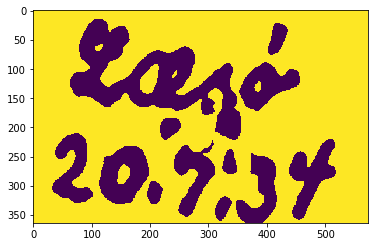

In [162]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, init=np.array([[0],[255]])).fit(np.expand_dims(word_img.flatten(),axis=1))
plt.imshow(kmeans.predict(word_img.reshape(-1,1)).reshape(word_img.shape))

/home/rob/anaconda3/envs/hwrtf/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


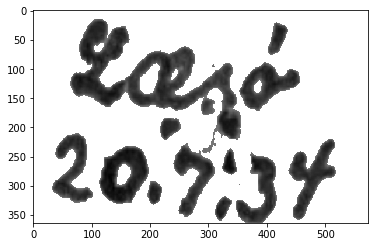

In [170]:

    
    #compute kmeans on histogram to split into writing and non
    

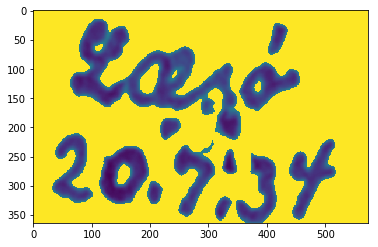

In [166]:

plt.imshow(word_img)

In [100]:
df = pd.read_csv('../06. Make Fake Labels/box coords aarhus.csv',index_col = 0)
df

,catalog_no,id,sx,sy,ex,ey,orig_fp,angle,type
0,NHMA-ENT-199269-lab.jpg,0,217,214,526,410,/home/rob/HWR/datasets/Aarhus/NHMA-ENT-199269-...,2.868719,HWR
1,NHMA-ENT-199269-lab.jpg,1,553,259,867,440,/home/rob/HWR/datasets/Aarhus/NHMA-ENT-199269-...,4.749293,HWR
2,NHMA-ENT-199269-lab.jpg,2,362,450,654,630,/home/rob/HWR/datasets/Aarhus/NHMA-ENT-199269-...,5.759731,Mix
3,NHMA-ENT-199244-lab.jpg,0,296,286,812,489,/home/rob/HWR/datasets/Aarhus/NHMA-ENT-199244-...,-1.551053,Mix
4,NHMA-ENT-199244-lab.jpg,1,440,531,621,655,/home/rob/HWR/datasets/Aarhus/NHMA-ENT-199244-...,-1.051181,HWR
5,NHMA-ENT-199370-lab.jpg,0,257,60,771,251,/home/rob/HWR/datasets/Aarhus/NHMA-ENT-199370-...,2.846707,OCR
6,NHMA-ENT-199370-lab.jpg,1,116,225,833,547,/home/rob/HWR/datasets/Aarhus/NHMA-ENT-199370-...,2.871674,OCR
7,NHMA-ENT-199370-lab.jpg,2,396,553,633,679,/home/rob/HWR/datasets/Aarhus/NHMA-ENT-199370-...,-1.037840,OCR
8,NHMA-ENT-199028-lab.jpg,0,194,178,521,413,/home/rob/HWR/datasets/Aarhus/NHMA-ENT-199028-...,3.660059,HWR
9,NHMA-ENT-199028-lab.jpg,1,525,239,827,408,/home/rob/HWR/datasets/Aarhus/NHMA-ENT-199028-...,2.569686,HWR
